Thanks for:

These notebooks: https://www.kaggle.com/maunish/osic-super-cool-eda-and-pytorch-baseline#6-Simple-Pytorch-Model
https://www.kaggle.com/carlossouza/bayesian-experiments


In [1]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [2]:
import albumentations
import copy
import cv2
#import gdcm
#import dicom

from efficientnet_pytorch import model as enet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import pydicom
import pymc3 as pm

import random

import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,PowerTransformer
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from skimage import exposure

import time
from tqdm import notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler

print("PyTorch Version: ",torch.__version__)
print(f"sklern: {sklearn.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.1
sklern: 0.23.2
cpu


# Config

In [3]:
data_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression/"

df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
sample = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

image_folder = os.path.join(data_dir + 'test/')
model_dir = os.path.join(data_dir+'oscitrainedmodels')


kernel_type = 'train_effnet_b0'
enet_type = 'efficientnet-b0'

test_bs = 16
n_epochs = 9999

In [4]:
random_seed = 42

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(random_seed)

In [5]:
#https://www.kaggle.com/unforgiven/osic-comprehensive-eda

import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu, median
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border
from scipy.stats import describe

def load_scan(dicom_dir):
  files = os.listdir(dicom_dir)  
  files.sort(key=lambda x: (int(x[:-4]), x[:-3]))
  dcms = []
  len_files = len(files)

  if len_files < 15:
    Point = 2*len(files)//10+2
    dicom_file = os.path.join(dicom_dir, files[Point])
    dcms.append(dicom_file)

  elif len_files < 33: # 25% percentile
    Point = 3*len(files)//10
    Range = 3
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)

  elif len_files > 500: # 75% percentile
    Point = 6*len(files)//10
    Range = 7
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)
  else:
    Point = 4*len(files)//10
    Range = 5
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)
      
  slices = []
  for scan in  dcms:
        with pydicom.dcmread(scan) as s:
            slices.append(s)
    
  slices.sort(key = lambda x: int(x.InstanceNumber))

  try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
    
  for s in slices:
        s.SliceThickness = slice_thickness
        
  return slices

def get_pixels_hu(slices):
    imags = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    imags = imags.astype(np.int16)
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    if slices[0].RescaleIntercept == -1024:
       imags[imags <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    center = slices[0].WindowCenter

    try:thresh = center*0.9
    except:thresh = center[0]*0.9
    
    if slope != 1:
        imags = slope * image.astype(np.float64)
        imags = image.astype(np.int16)
        
    imags += np.int16(intercept)

    imags = np.array(imags, dtype=np.int16)


    binaries = []
    for imag in imags:
      binary = imag <= thresh
      binaries.append(binary)
    mean_img = np.mean(binaries, axis=0)
    
    return mean_img

def conv_img(mean_img):
  h, w = mean_img.shape[:2]
  if h == w:
    h1, h2 = int(h * 0.33), int(h * 0.7)
    w1, w2 = int(w * 0.13), int(w * 0.87)
  if h > w:
    a, b = h/w, w/h
    h1, h2 = int(h * 0.3*a), int(h * 0.7*b)
    w1, w2 = int(w * 0.13), int(w * 0.87)
  if h < w:
    a, b = w/h, h/w
    h1, h2 = int(h * 0.4), int(h * 0.67)
    w1, w2 = int(w * 0.3*a), int(w * 0.8*b)
    

  mean_img = mean_img[h1: h2, w1: w2]
  mean_img = cv2.resize(mean_img, (512, 512))

  stacked_img = np.stack((mean_img,)*3, -1)
  stacked_img = exposure.equalize_adapthist(stacked_img)
  

  return stacked_img

In [6]:
from collections import defaultdict

data_dic = defaultdict()

for pt_id in tqdm.tqdm(set(list(df_test.Patient))):
  dicom_dir = os.path.join(image_folder, pt_id)
  patient = load_scan(dicom_dir)
  mean_img = get_pixels_hu(patient)
  stacked_img = conv_img(mean_img)
  data_dic[dicom_dir]=stacked_img

# Dataset

In [7]:
class OsciDataset(Dataset):
    
  def __init__(self, image_paths, data_dic, targets, augmentations=None, meta_features = None):
      """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
      """
      self.image_paths = image_paths
      self.data_dic = data_dic
      self.targets = targets
      self.augmentations = augmentations
      self.meta_features = meta_features

  def __len__(self):
      return len(self.image_paths)

  def get_targets(self):
      return list(self.targets)

  def __getitem__(self, idx):
      img = self.data_dic[self.image_paths[idx]]
      
      if self.augmentations is not None:
          augmented = self.augmentations(image=img)
          img = augmented["image"]
            
      if self.meta_features is not None:
        meta = self.meta_features[idx]
        meta = torch.tensor(meta)
        
      stacked_img = img.transpose(2, 0, 1)
      
      targets = self.targets[idx]

      return {
            "image": (torch.tensor(stacked_img), meta),
            "targets": torch.tensor(targets),
        }

# Augmentations

In [8]:
valid_aug = albumentations.Compose([])

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


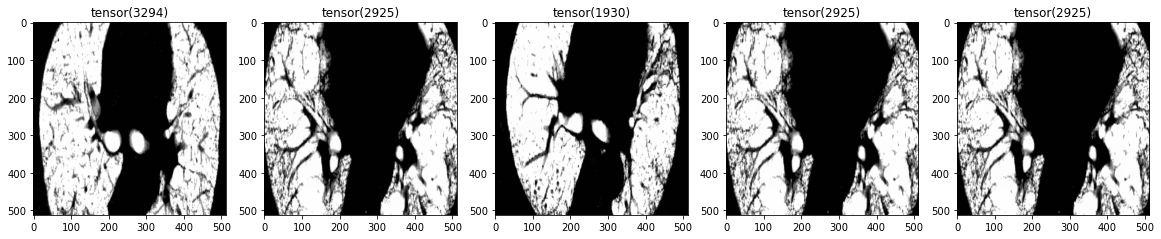

In [9]:
tmp_pt_id = df_test.Patient.values.tolist()
tmp_images_dir = [os.path.join(image_folder, tmp_pt_id[i]) for i in range(len(tmp_pt_id))]
tmp_targets = df_test.FVC.values
tmp_meta = np.array(df_test['Weeks'].values, dtype=np.float32)

dataset_show = OsciDataset(image_paths = tmp_images_dir, data_dic=data_dic, targets=tmp_targets, augmentations=valid_aug, meta_features = tmp_meta)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

fig, axes = plt.subplots(1, 5)
for i in range(5):
  idx = np.random.randint(0, len(dataset_show))
  data = dataset_show[idx]
  imag, _ = data["image"]
  print(imag.shape)
  axes[i].imshow(imag.transpose(0, 1).transpose(1, 2).squeeze())
  axes[i].set_title(data["targets"])

# Model

In [10]:
class MyBatchNorm1d(nn.BatchNorm1d):
    def __init__(self, *kargs, **kwargs):
        super(MyBatchNorm1d, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        self.running_var.data = torch.round(self.running_var.data)
        
        out = F.batch_norm(input, self.running_mean, self.running_var,self.weight, self.bias, self.training, self.momentum, self.eps)
        
        return out

In [11]:
class enetv2(nn.Module):
    def __init__(self, backbone, n_features: int):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        #self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        
        self.cnn = nn.Sequential(nn.Linear(self.enet._fc.in_features, 250, bias=True),
                                 MyBatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1)
                                 )

        self.meta = nn.Sequential(nn.Linear(n_features, 500, bias=True),
                                  MyBatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.25),
                                  nn.Linear(500, 250),  
                                  MyBatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.25)
                                  )
        
        self.enet._fc = nn.Identity()
        self.out = nn.Linear(250 + 250, 3)
        
    def extract(self, x):
        return self.enet(x)

    def forward(self, inputs):
        x, meta = inputs
        x = self.extract(x)
        x = self.cnn(x)
        meta = self.meta(meta)
        x = torch.cat((x, meta), 1)
        out = self.out(x)
        
        return out

In [12]:
model_files = []

for file in os.listdir("../input/oscitrainedmodels/"):
    if ".pth" in file:
        model_files.append(file)
model_files

['20200925_v12_train_effnet_b0_best_fold1.pth',
 '20200925_v12_train_effnet_b0_best_fold4.pth',
 '20200925_v12_train_effnet_b0_best_fold2.pth',
 '20200925_v12_train_effnet_b0_best_fold3.pth']

In [13]:
def load_models(model_files):
    models = []
    for model_f in model_files:
        model_f = os.path.join("../input/oscitrainedmodels", model_f)
        backbone = 'efficientnet-b0'
        n_features = 158
        model = enetv2(backbone, n_features)
        model.load_state_dict(torch.load(model_f, map_location=lambda storage, loc: storage), strict=True)
        model.eval()
        model.to(device)
        models.append(model)
        print(f'{model_f} loaded!')
    return models

In [14]:
models = load_models(model_files)

../input/oscitrainedmodels/20200925_v12_train_effnet_b0_best_fold1.pth loaded!
../input/oscitrainedmodels/20200925_v12_train_effnet_b0_best_fold4.pth loaded!
../input/oscitrainedmodels/20200925_v12_train_effnet_b0_best_fold2.pth loaded!
../input/oscitrainedmodels/20200925_v12_train_effnet_b0_best_fold3.pth loaded!


# Create testset data with Bayesian approach

https://colab.research.google.com/drive/13WTKUlpYEtN0RNhzax_j8gbf84FuU1CF?authuser=1#scrollTo=jUeafaYrv9Em

In [15]:
tr = df_train.copy()
ts = df_test.copy()
tr = pd.concat([tr, ts], axis=0, ignore_index=True).drop_duplicates()
le_id = LabelEncoder()
tr['PatientID'] = le_id.fit_transform(tr['Patient'])

In [16]:
n_patients = tr['Patient'].nunique()
FVC_obs = tr['FVC'].values
Weeks = tr['Weeks'].values
PatientID = tr['PatientID'].values

with pm.Model() as model_a:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)
    
    # Fitting the model
    trace_a = pm.sample(2000, tune=2000, target_accept=.9, init="adapt_diag")

In [17]:
pred_template = []
for p in tｓ['Patient'].unique():
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['Patient'] = p
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)
pred_template['PatientID'] = le_id.transform(pred_template['Patient'])

with model_a:
    pm.set_data({
        "PatientID_shared": pred_template['PatientID'].values.astype(int),
        "Weeks_shared": pred_template['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_template)).astype(int),
    })
    post_pred = pm.sample_posterior_predictive(trace_a)

In [18]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'Patient_Week', 'FVC', 'Confidence'])
df['Patient'] = pred_template['Patient']
df['Weeks'] = pred_template['Weeks']
df['Patient_Week'] = df['Patient'] + '_' + df['Weeks'].astype(str)
df['FVC'] = post_pred['FVC_like'].T.mean(axis=1)
df['Confidence'] = post_pred['FVC_like'].T.std(axis=1)
final = df[['Patient_Week', 'FVC', 'Confidence']]
final.to_csv('submission.csv', index=False)
print(final.shape)
final

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2867.661386,162.483484
1,ID00419637202311204720264_-11,2870.346891,162.487260
2,ID00419637202311204720264_-10,2864.960188,158.986447
3,ID00419637202311204720264_-9,2859.027769,156.728646
4,ID00419637202311204720264_-8,2858.710315,159.027809
...,...,...,...
725,ID00426637202313170790466_129,2713.541328,281.048902
726,ID00426637202313170790466_130,2717.872827,278.869184
727,ID00426637202313170790466_131,2715.517531,281.325573
728,ID00426637202313170790466_132,2711.163255,288.061208


# Create meta featuers

In [19]:
#getting base week for patient
def get_baseline_week(data):
    df = data.copy()
    df['Weeks'] = df['Weeks'].astype(int)
    df['min_week'] = df.groupby('Patient')['Weeks'].transform('min')
    df['baseline_week'] = df['Weeks'] - df['min_week']
    return df

#getting FVC for base week and setting it as base_FVC of patient
def get_base_FVC(data):
    df = data.copy()
    base = df.loc[df.Weeks == df.min_week][['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    base['nb']=1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    base = base[base.nb==1]
    base.drop('nb',axis =1,inplace=True)
    df = df.merge(base,on="Patient",how='left')
    df.drop(['min_week'], axis = 1)
    return df 

#For Inference
#getting Number of CT 
def get_N_CT(data, mode="test"):
    df = data.copy()
    N_CT = []
    for pt_id in df.Patient:
      if mode is "test":
        png_dir = os.path.join(image_folder, pt_id)
      if mode is "train":
        png_dir = os.path.join(data_dir, 'train', pt_id)
      files = os.listdir(png_dir)
      N_CT.append(len(files))
    df["N_CT"] = N_CT
    return df


# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-8
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in  tqdm.tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm.tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [20]:
df_train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
df_train = get_baseline_week(df_train)
df_train = get_base_FVC(df_train)
df_train = get_N_CT(df_train, "train")
df_test = get_N_CT(df_test)

sample.drop("FVC", axis=1,inplace=True)
sample[["Patient","Weeks"]] = sample["Patient_Week"].str.split("_",expand=True) 
sample = sample.merge(df_test.drop("Weeks",axis=1),on="Patient",how="left")

#we have to predict for all weeks 
sample["min_Weeks"] = np.nan
sample = get_baseline_week(sample)

In [21]:
sample

,Patient_Week,Confidence,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,N_CT,min_Weeks,min_week,baseline_week
0,ID00419637202311204720264_-12,100,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,28,NaN,-12,0
1,ID00421637202311550012437_-12,100,ID00421637202311550012437,-12,2739,82.045291,68,Male,Ex-smoker,62,NaN,-12,0
2,ID00422637202311677017371_-12,100,ID00422637202311677017371,-12,1930,76.672493,73,Male,Ex-smoker,473,NaN,-12,0
3,ID00423637202312137826377_-12,100,ID00423637202312137826377,-12,3294,79.258903,72,Male,Ex-smoker,290,NaN,-12,0
4,ID00426637202313170790466_-12,100,ID00426637202313170790466,-12,2925,71.824968,73,Male,Never smoked,408,NaN,-12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264_133,100,ID00419637202311204720264,133,3020,70.186855,73,Male,Ex-smoker,28,NaN,-12,145
726,ID00421637202311550012437_133,100,ID00421637202311550012437,133,2739,82.045291,68,Male,Ex-smoker,62,NaN,-12,145
727,ID00422637202311677017371_133,100,ID00422637202311677017371,133,1930,76.672493,73,Male,Ex-smoker,473,NaN,-12,145
728,ID00423637202312137826377_133,100,ID00423637202312137826377,133,3294,79.258903,72,Male,Ex-smoker,290,NaN,-12,145


# Reassign the predicted FVC


In [22]:
sample = sample.drop(columns='FVC').merge(final[["Patient_Week", "FVC"]], on='Patient_Week')

In [23]:
sample

,Patient_Week,Confidence,Patient,Weeks,Percent,Age,Sex,SmokingStatus,N_CT,min_Weeks,min_week,baseline_week,FVC
0,ID00419637202311204720264_-12,100,ID00419637202311204720264,-12,70.186855,73,Male,Ex-smoker,28,NaN,-12,0,2867.661386
1,ID00421637202311550012437_-12,100,ID00421637202311550012437,-12,82.045291,68,Male,Ex-smoker,62,NaN,-12,0,2853.429916
2,ID00422637202311677017371_-12,100,ID00422637202311677017371,-12,76.672493,73,Male,Ex-smoker,473,NaN,-12,0,2043.958773
3,ID00423637202312137826377_-12,100,ID00423637202312137826377,-12,79.258903,72,Male,Ex-smoker,290,NaN,-12,0,3109.338569
4,ID00426637202313170790466_-12,100,ID00426637202313170790466,-12,71.824968,73,Male,Never smoked,408,NaN,-12,0,2951.874118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264_133,100,ID00419637202311204720264,133,70.186855,73,Male,Ex-smoker,28,NaN,-12,145,2490.090810
726,ID00421637202311550012437_133,100,ID00421637202311550012437,133,82.045291,68,Male,Ex-smoker,62,NaN,-12,145,2569.419837
727,ID00422637202311677017371_133,100,ID00422637202311677017371,133,76.672493,73,Male,Ex-smoker,473,NaN,-12,145,1350.756099
728,ID00423637202312137826377_133,100,ID00423637202312137826377,133,79.258903,72,Male,Ex-smoker,290,NaN,-12,145,1941.410386


In [24]:
# PercentをFVCに合わせて補正
# X * Percent / 100 = FVC
# X = FVC * 100 / Percent

dic = {}
for i in range(len(df_test)):
    X = int(df_test.FVC[i]*100/df_test.Percent[i])
    dic[df_test.Patient[i]] = X
dic

{'ID00419637202311204720264': 4302,
 'ID00421637202311550012437': 3338,
 'ID00422637202311677017371': 2517,
 'ID00423637202312137826377': 4156,
 'ID00426637202313170790466': 4072}

In [25]:
#sample["FVC"] *= 0.996

In [26]:
# Percent = FVC * 100 /X

for i in range(len(sample)):
    Percent = sample.FVC[i]*100 / dic[sample.Patient[i]]
    sample.Percent[i] = Percent
sample

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Patient_Week,Confidence,Patient,Weeks,Percent,Age,Sex,SmokingStatus,N_CT,min_Weeks,min_week,baseline_week,FVC
0,ID00419637202311204720264_-12,100,ID00419637202311204720264,-12,66.658796,73,Male,Ex-smoker,28,NaN,-12,0,2867.661386
1,ID00421637202311550012437_-12,100,ID00421637202311550012437,-12,85.483221,68,Male,Ex-smoker,62,NaN,-12,0,2853.429916
2,ID00422637202311677017371_-12,100,ID00422637202311677017371,-12,81.206149,73,Male,Ex-smoker,473,NaN,-12,0,2043.958773
3,ID00423637202312137826377_-12,100,ID00423637202312137826377,-12,74.815654,72,Male,Ex-smoker,290,NaN,-12,0,3109.338569
4,ID00426637202313170790466_-12,100,ID00426637202313170790466,-12,72.491997,73,Male,Never smoked,408,NaN,-12,0,2951.874118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264_133,100,ID00419637202311204720264,133,57.882167,73,Male,Ex-smoker,28,NaN,-12,145,2490.090810
726,ID00421637202311550012437_133,100,ID00421637202311550012437,133,76.974830,68,Male,Ex-smoker,62,NaN,-12,145,2569.419837
727,ID00422637202311677017371_133,100,ID00422637202311677017371,133,53.665320,73,Male,Ex-smoker,473,NaN,-12,145,1350.756099
728,ID00423637202312137826377_133,100,ID00423637202312137826377,133,46.713436,72,Male,Ex-smoker,290,NaN,-12,145,1941.410386


In [27]:
sample = get_base_FVC(sample)

train_columns = ['Patient', 'FVC', 'baseline_week','base_FVC','Percent','Age','Sex','SmokingStatus', "N_CT"]

train = df_train[train_columns]
test = sample[train_columns]

train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)

data = data.reset_index(drop=True)
Splitdata=data['WHERE']
data = data.drop(columns='WHERE')

data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT
0,ID00007637202177411956430,2315.000000,0,2315.000000,58.253649,79,Male,Ex-smoker,30
1,ID00007637202177411956430,2214.000000,9,2315.000000,55.712129,79,Male,Ex-smoker,30
2,ID00007637202177411956430,2061.000000,11,2315.000000,51.862104,79,Male,Ex-smoker,30
3,ID00007637202177411956430,2144.000000,13,2315.000000,53.950679,79,Male,Ex-smoker,30
4,ID00007637202177411956430,2069.000000,15,2315.000000,52.063412,79,Male,Ex-smoker,30
...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,73,Male,Ex-smoker,28
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,68,Male,Ex-smoker,62
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,73,Male,Ex-smoker,473
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,72,Male,Ex-smoker,290


In [28]:
Encoding = {"Currently smokes": 2, "Ex-smoker": 1, "Never smoked": 0, "Male": 1, "Female":0}
data['SmokingStatus'] = data.SmokingStatus.map(Encoding)
data["Sex"] = data.Sex.map(Encoding)

In [29]:
data['week'] = (data['baseline_week'] - data['baseline_week'].min() ) / ( data['baseline_week'].max() - data['baseline_week'].min())
data['percent'] = (data['Percent'] - data['Percent'].min() ) / (data['Percent'].max() - data['Percent'].min())

In [30]:
Age = []
for i in range(len(data)):
  Pt_base_age = data.Age[data.Patient == data.Patient[i]].min()
  # 365/7 = 52.14
  # 1/52.14 = 0.01917
  Pt_age = 0.0192*data.baseline_week[i] + Pt_base_age
  Age.append(Pt_age)

data["Age"] = Age
data

,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT,week,percent
0,ID00007637202177411956430,2315.000000,0,2315.000000,58.253649,79.0000,1,1,30,0.000000,0.236393
1,ID00007637202177411956430,2214.000000,9,2315.000000,55.712129,79.1728,1,1,30,0.062069,0.215941
2,ID00007637202177411956430,2061.000000,11,2315.000000,51.862104,79.2112,1,1,30,0.075862,0.184960
3,ID00007637202177411956430,2144.000000,13,2315.000000,53.950679,79.2496,1,1,30,0.089655,0.201767
4,ID00007637202177411956430,2069.000000,15,2315.000000,52.063412,79.2880,1,1,30,0.103448,0.186580
...,...,...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,75.7840,1,1,28,1.000000,0.233404
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,70.7840,1,1,62,1.000000,0.387045
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,75.7840,1,1,473,1.000000,0.199470
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,74.7840,1,1,290,1.000000,0.143528


In [31]:
data['age'] = (data['Age'] - data['Age'].min() ) / (data['Age'].max() - data['Age'].min())

In [32]:
# typical_FVC_cluster
fvc_cluster = {}

set_fvc = sorted(list(set(round(data.FVC/data.Percent*100, -2))))
for idx, fvc in enumerate(set_fvc, 1):
  fvc_cluster[fvc] = idx
fvc_cluster

{1600.0: 1,
 1700.0: 2,
 1800.0: 3,
 1900.0: 4,
 2000.0: 5,
 2100.0: 6,
 2200.0: 7,
 2300.0: 8,
 2400.0: 9,
 2500.0: 10,
 2700.0: 11,
 2800.0: 12,
 2900.0: 13,
 3000.0: 14,
 3100.0: 15,
 3200.0: 16,
 3300.0: 17,
 3400.0: 18,
 3500.0: 19,
 3600.0: 20,
 3700.0: 21,
 3800.0: 22,
 3900.0: 23,
 4000.0: 24,
 4100.0: 25,
 4200.0: 26,
 4300.0: 27,
 4400.0: 28,
 4500.0: 29,
 4600.0: 30,
 4700.0: 31,
 4800.0: 32,
 4900.0: 33}

In [33]:
typical_FVC_cluster = []
for i in range(len(data)):
  typical_FVC = round(data.FVC[i]/data.Percent[i]*100, -2)
  typical_FVC_cluster.append(fvc_cluster[typical_FVC])

data["typical_FVC_cluster"] = typical_FVC_cluster
data

,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT,week,percent,age,typical_FVC_cluster
0,ID00007637202177411956430,2315.000000,0,2315.000000,58.253649,79.0000,1,1,30,0.000000,0.236393,0.746447,24
1,ID00007637202177411956430,2214.000000,9,2315.000000,55.712129,79.1728,1,1,30,0.062069,0.215941,0.750746,24
2,ID00007637202177411956430,2061.000000,11,2315.000000,51.862104,79.2112,1,1,30,0.075862,0.184960,0.751702,24
3,ID00007637202177411956430,2144.000000,13,2315.000000,53.950679,79.2496,1,1,30,0.089655,0.201767,0.752657,24
4,ID00007637202177411956430,2069.000000,15,2315.000000,52.063412,79.2880,1,1,30,0.103448,0.186580,0.753613,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,75.7840,1,1,28,1.000000,0.233404,0.666428,27
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,70.7840,1,1,62,1.000000,0.387045,0.542020,17
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,75.7840,1,1,473,1.000000,0.199470,0.666428,10
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,74.7840,1,1,290,1.000000,0.143528,0.641546,26


In [34]:
# log transform
data["N_CT"] = np.log1p(data.N_CT)
data["log_baseline_week"] = np.log1p(data.baseline_week)  

In [35]:
tmp1 = CreateFeat(data[["log_baseline_week", "Age"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,8:])
data = pd.concat([data.iloc[:,:8], tmp１], axis=1)
data


Crated 4 columns


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Removed 10 constant & duplicated columns


,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT,week,percent,age,typical_FVC_cluster,log_baseline_week,Age_log_baseline_week_prd,Age_log_baseline_week_div
0,ID00007637202177411956430,2315.000000,0,2315.000000,58.253649,79.0000,1,1,3.433987,0.000000,0.236393,0.746447,24,0.000000,0.000000,7.900000e+09
1,ID00007637202177411956430,2214.000000,9,2315.000000,55.712129,79.1728,1,1,3.433987,0.062069,0.215941,0.750746,24,2.302585,182.302109,3.400000e+01
2,ID00007637202177411956430,2061.000000,11,2315.000000,51.862104,79.2112,1,1,3.433987,0.075862,0.184960,0.751702,24,2.484907,196.832438,3.200000e+01
3,ID00007637202177411956430,2144.000000,13,2315.000000,53.950679,79.2496,1,1,3.433987,0.089655,0.201767,0.752657,24,2.639057,209.144238,3.000000e+01
4,ID00007637202177411956430,2069.000000,15,2315.000000,52.063412,79.2880,1,1,3.433987,0.103448,0.186580,0.753613,24,2.772589,219.833015,2.900000e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,75.7840,1,1,3.367296,1.000000,0.233404,0.666428,27,4.983607,377.677644,1.500000e+01
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,70.7840,1,1,4.143135,1.000000,0.387045,0.542020,17,4.983607,352.759611,1.400000e+01
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,75.7840,1,1,6.161207,1.000000,0.199470,0.666428,10,4.983607,377.677644,1.500000e+01
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,74.7840,1,1,5.673323,1.000000,0.143528,0.641546,26,4.983607,372.694038,1.500000e+01


In [36]:
tmp1 = CreateFeat(data[["N_CT", "age"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,8:])
data = pd.concat([data.iloc[:,:8], tmp１], axis=1)
data


Crated 4 columns


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Removed 12 constant & duplicated columns


,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT,week,percent,age,typical_FVC_cluster,log_baseline_week,Age_log_baseline_week_prd,Age_log_baseline_week_div,N_CT_age_div,age_N_CT_prd
0,ID00007637202177411956430,2315.000000,0,2315.000000,58.253649,79.0000,1,1,3.433987,0.000000,0.236393,0.746447,24,0.000000,0.000000,7.900000e+09,5.0,2.563289
1,ID00007637202177411956430,2214.000000,9,2315.000000,55.712129,79.1728,1,1,3.433987,0.062069,0.215941,0.750746,24,2.302585,182.302109,3.400000e+01,5.0,2.578054
2,ID00007637202177411956430,2061.000000,11,2315.000000,51.862104,79.2112,1,1,3.433987,0.075862,0.184960,0.751702,24,2.484907,196.832438,3.200000e+01,5.0,2.581335
3,ID00007637202177411956430,2144.000000,13,2315.000000,53.950679,79.2496,1,1,3.433987,0.089655,0.201767,0.752657,24,2.639057,209.144238,3.000000e+01,5.0,2.584616
4,ID00007637202177411956430,2069.000000,15,2315.000000,52.063412,79.2880,1,1,3.433987,0.103448,0.186580,0.753613,24,2.772589,219.833015,2.900000e+01,5.0,2.587897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,75.7840,1,1,3.367296,1.000000,0.233404,0.666428,27,4.983607,377.677644,1.500000e+01,5.0,2.244060
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,70.7840,1,1,4.143135,1.000000,0.387045,0.542020,17,4.983607,352.759611,1.400000e+01,8.0,2.245662
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,75.7840,1,1,6.161207,1.000000,0.199470,0.666428,10,4.983607,377.677644,1.500000e+01,9.0,4.106000
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,74.7840,1,1,5.673323,1.000000,0.143528,0.641546,26,4.983607,372.694038,1.500000e+01,9.0,3.639699


In [37]:
# clipping
clipping = data.columns[8:]
for col in clipping:
  upperbound, lowerbound = np.percentile(data[col], [1, 99])
  data[col] = np.clip(data[col], upperbound, lowerbound)

In [38]:
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")#, "skew","kurt")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm.tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

tmp = CreateFeat2(data[["week", "percent", "age", "log_baseline_week", "Age_log_baseline_week_prd", "Age_log_baseline_week_div", "N_CT_age_div", "age_N_CT_prd"]])

data = pd.concat([data, tmp], axis=1)
data= data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,8:])
data = pd.concat([data.iloc[:,:8], tmp], axis=1)

data

0/7: Calucurating... max



1/7: Calucurating... min


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 392 columns



Removed 250 constant & duplicated columns


,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT,typical_FVC_cluster,...,N_CT_age_div_log_baseline_week_std,N_CT_age_div_Age_log_baseline_week_prd_std,N_CT_age_div_Age_log_baseline_week_div_std,age_N_CT_prd_week_std,age_N_CT_prd_percent_std,age_N_CT_prd_age_std,age_N_CT_prd_log_baseline_week_std,age_N_CT_prd_Age_log_baseline_week_prd_std,age_N_CT_prd_Age_log_baseline_week_div_std,age_N_CT_prd_N_CT_age_div_std
0,ID00007637202177411956430,2315.000000,0,2315.000000,58.253649,79.0000,1,1,3.433987,24,...,3.535534,3.535534,5.232590e+09,1.812519,1.645364,1.284701,1.812519,1.812519,5.232590e+09,1.723015
1,ID00007637202177411956430,2214.000000,9,2315.000000,55.712129,79.1728,1,1,3.433987,24,...,1.907360,125.371524,2.050610e+01,1.779070,1.670266,1.292101,0.194786,127.084098,2.221867e+01,1.712575
2,ID00007637202177411956430,2061.000000,11,2315.000000,51.862104,79.2112,1,1,3.433987,24,...,1.778440,135.646017,1.909188e+01,1.771637,1.694493,1.293746,0.068185,137.356272,2.080214e+01,1.710255
3,ID00007637202177411956430,2144.000000,13,2315.000000,53.950679,79.2496,1,1,3.433987,24,...,1.669439,144.351775,1.767767e+01,1.764204,1.684929,1.295390,0.038496,146.059709,1.938560e+01,1.707935
4,ID00007637202177411956430,2069.000000,15,2315.000000,52.063412,79.2880,1,1,3.433987,24,...,1.575018,151.909881,1.697056e+01,1.756770,1.697988,1.297035,0.130597,153.615496,1.867618e+01,1.705615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,75.7840,1,1,3.367296,27,...,0.031235,260.421049,7.071068e+00,0.899189,1.421748,1.115554,1.917509,262.369793,9.019812e+00,1.948744
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,70.7840,1,1,4.143135,17,...,2.152555,243.781859,4.242641e+00,0.900322,1.314240,1.204657,1.916376,247.850790,8.311572e+00,4.068932
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,75.7840,1,1,6.161207,10,...,2.859662,257.592622,4.242641e+00,2.206123,2.752676,2.422488,0.610576,261.062860,7.712878e+00,3.470238
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,74.7840,1,1,5.673323,26,...,2.859662,257.170520,4.242641e+00,1.886056,2.472167,2.120014,0.930643,260.960825,8.032946e+00,3.790305


In [39]:
# clipping
clipping = data.columns[8:]
for col in clipping:
  upperbound, lowerbound = np.percentile(data[col], [1, 99])
  data[col] = np.clip(data[col], upperbound, lowerbound)

In [40]:
data['WHERE'] = Splitdata
data

,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT,typical_FVC_cluster,...,N_CT_age_div_Age_log_baseline_week_prd_std,N_CT_age_div_Age_log_baseline_week_div_std,age_N_CT_prd_week_std,age_N_CT_prd_percent_std,age_N_CT_prd_age_std,age_N_CT_prd_log_baseline_week_std,age_N_CT_prd_Age_log_baseline_week_prd_std,age_N_CT_prd_Age_log_baseline_week_div_std,age_N_CT_prd_N_CT_age_div_std,WHERE
0,ID00007637202177411956430,2315.000000,0,2315.000000,58.253649,79.0000,1,1,3.433987,24,...,4.242641,5.232590e+09,1.812519,1.645364,1.284701,1.812519,1.812519,5.232590e+09,1.723015,train
1,ID00007637202177411956430,2214.000000,9,2315.000000,55.712129,79.1728,1,1,3.433987,24,...,125.371524,2.050610e+01,1.779070,1.670266,1.292101,0.194786,127.084098,2.221867e+01,1.712575,train
2,ID00007637202177411956430,2061.000000,11,2315.000000,51.862104,79.2112,1,1,3.433987,24,...,135.646017,1.909188e+01,1.771637,1.694493,1.293746,0.068185,137.356272,2.080214e+01,1.710255,train
3,ID00007637202177411956430,2144.000000,13,2315.000000,53.950679,79.2496,1,1,3.433987,24,...,144.351775,1.767767e+01,1.764204,1.684929,1.295390,0.038496,146.059709,1.938560e+01,1.707935,train
4,ID00007637202177411956430,2069.000000,15,2315.000000,52.063412,79.2880,1,1,3.433987,24,...,151.909881,1.697056e+01,1.756770,1.697988,1.297035,0.130597,153.615496,1.867618e+01,1.705615,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,75.7840,1,1,3.367296,27,...,257.592622,7.071068e+00,0.899189,1.421748,1.115554,1.917509,261.062860,9.019812e+00,1.948744,test
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,70.7840,1,1,4.143135,17,...,243.781859,4.242641e+00,0.900322,1.314240,1.204657,1.916376,247.850790,8.311572e+00,4.068932,test
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,75.7840,1,1,6.161207,10,...,257.592622,4.242641e+00,2.206123,2.692608,2.406063,0.610576,261.062860,7.786214e+00,3.470238,test
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,74.7840,1,1,5.673323,26,...,257.170520,4.242641e+00,1.886056,2.472167,2.120014,0.930643,260.960825,8.032946e+00,3.790305,test


In [41]:
test = data[data['WHERE']=="test"]
test

,Patient,FVC,baseline_week,base_FVC,Percent,Age,Sex,SmokingStatus,N_CT,typical_FVC_cluster,...,N_CT_age_div_Age_log_baseline_week_prd_std,N_CT_age_div_Age_log_baseline_week_div_std,age_N_CT_prd_week_std,age_N_CT_prd_percent_std,age_N_CT_prd_age_std,age_N_CT_prd_log_baseline_week_std,age_N_CT_prd_Age_log_baseline_week_prd_std,age_N_CT_prd_Age_log_baseline_week_div_std,age_N_CT_prd_N_CT_age_div_std,WHERE
1535,ID00419637202311204720264,2867.661386,0,2867.661386,66.658796,73.000,1,1,3.367296,27,...,4.242641,5.161879e+09,1.421855,1.206872,0.999600,1.421855,1.421855,5.161880e+09,2.820786,test
1536,ID00421637202311550012437,2853.429916,0,2853.429916,85.483221,68.000,1,1,4.143135,17,...,6.363961,4.808326e+09,1.384986,1.062889,1.050701,1.384986,1.384986,4.808326e+09,4.978975,test
1537,ID00422637202311677017371,2043.958773,0,2043.958773,81.206149,73.000,1,1,6.161207,10,...,7.071068,5.161879e+09,2.601595,2.303836,2.179341,2.463237,2.601595,5.161880e+09,4.469473,test
1538,ID00423637202312137826377,3109.338569,0,3109.338569,74.815654,72.000,1,1,5.673323,26,...,7.071068,5.091169e+09,2.295768,2.034372,1.891108,2.295768,2.295768,5.091169e+09,4.775300,test
1539,ID00426637202313170790466,2951.874118,0,2951.874118,72.491997,73.000,1,0,6.013715,25,...,7.071068,5.161879e+09,2.539316,2.291142,2.117062,2.463237,2.539316,5.161880e+09,4.531752,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,ID00419637202311204720264,2490.090810,145,2867.661386,57.882167,75.784,1,1,3.367296,27,...,257.592622,7.071068e+00,0.899189,1.421748,1.115554,1.917509,261.062860,9.019812e+00,1.948744,test
2261,ID00421637202311550012437,2569.419837,145,2853.429916,76.974830,70.784,1,1,4.143135,17,...,243.781859,4.242641e+00,0.900322,1.314240,1.204657,1.916376,247.850790,8.311572e+00,4.068932,test
2262,ID00422637202311677017371,1350.756099,145,2043.958773,53.665320,75.784,1,1,6.161207,10,...,257.592622,4.242641e+00,2.206123,2.692608,2.406063,0.610576,261.062860,7.786214e+00,3.470238,test
2263,ID00423637202312137826377,1941.410386,145,3109.338569,46.713436,74.784,1,1,5.673323,26,...,257.170520,4.242641e+00,1.886056,2.472167,2.120014,0.930643,260.960825,8.032946e+00,3.790305,test


In [42]:
test.columns[2:-1]

Index(['baseline_week', 'base_FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'N_CT', 'typical_FVC_cluster', 'percent_week_max', 'age_week_max',
       ...
       'N_CT_age_div_log_baseline_week_std',
       'N_CT_age_div_Age_log_baseline_week_prd_std',
       'N_CT_age_div_Age_log_baseline_week_div_std', 'age_N_CT_prd_week_std',
       'age_N_CT_prd_percent_std', 'age_N_CT_prd_age_std',
       'age_N_CT_prd_log_baseline_week_std',
       'age_N_CT_prd_Age_log_baseline_week_prd_std',
       'age_N_CT_prd_Age_log_baseline_week_div_std',
       'age_N_CT_prd_N_CT_age_div_std'],
      dtype='object', length=158)

# Prediction

In [43]:
# Test data for inference
test_pt_id = test.Patient.values.tolist()
test_images_dir = [os.path.join(image_folder,test_pt_id[i]) for i in range(len(test_pt_id))]

test_targets = test.FVC.values

In [44]:
#Preprocessing
meta_col = test.columns[2:-1]
scaler = StandardScaler()

test = test[meta_col]
test_meta= scaler.fit_transform(test)  
test_meta = np.array(test_meta, dtype=np.float32)

test_dataset = OsciDataset(
    image_paths=test_images_dir,
    data_dic=data_dic,
    targets=test_targets,
    augmentations=valid_aug,
    meta_features=test_meta
    )

test_loader = torch.utils.data.DataLoader(
      test_dataset, 
      batch_size=test_bs, 
      shuffle=False, 
      num_workers=os.cpu_count(),
      pin_memory=True
      )

In [45]:
all_prediction = np.zeros((test.shape[0], 3))

for model in models:
    predictions = []
    with torch.no_grad():
        for data in tqdm.tqdm(test_loader):
          inputs = data["image"]


          inputs[0] = inputs[0].to(device, dtype=torch.float) 
          inputs[1] = inputs[1].to(device, dtype=torch.float)
          
          outputs = model(inputs)
          predictions.extend(outputs.cpu().detach().numpy())

    all_prediction += np.array(predictions)/len(models)

In [46]:
sample

,Patient_Week,Confidence,Patient,Weeks,Percent,Age,Sex,SmokingStatus,N_CT,min_Weeks,min_week,baseline_week,FVC,base_FVC
0,ID00419637202311204720264_-12,100,ID00419637202311204720264,-12,66.658796,73,Male,Ex-smoker,28,NaN,-12,0,2867.661386,2867.661386
1,ID00421637202311550012437_-12,100,ID00421637202311550012437,-12,85.483221,68,Male,Ex-smoker,62,NaN,-12,0,2853.429916,2853.429916
2,ID00422637202311677017371_-12,100,ID00422637202311677017371,-12,81.206149,73,Male,Ex-smoker,473,NaN,-12,0,2043.958773,2043.958773
3,ID00423637202312137826377_-12,100,ID00423637202312137826377,-12,74.815654,72,Male,Ex-smoker,290,NaN,-12,0,3109.338569,3109.338569
4,ID00426637202313170790466_-12,100,ID00426637202313170790466,-12,72.491997,73,Male,Never smoked,408,NaN,-12,0,2951.874118,2951.874118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264_133,100,ID00419637202311204720264,133,57.882167,73,Male,Ex-smoker,28,NaN,-12,145,2490.090810,2867.661386
726,ID00421637202311550012437_133,100,ID00421637202311550012437,133,76.974830,68,Male,Ex-smoker,62,NaN,-12,145,2569.419837,2853.429916
727,ID00422637202311677017371_133,100,ID00422637202311677017371,133,53.665320,73,Male,Ex-smoker,473,NaN,-12,145,1350.756099,2043.958773
728,ID00423637202312137826377_133,100,ID00423637202312137826377,133,46.713436,72,Male,Ex-smoker,290,NaN,-12,145,1941.410386,3109.338569


In [47]:
sample = sample.reset_index(drop=True)

In [48]:
for i in range(len(all_prediction)):
    sample["FVC"][i] = np.mean(all_prediction[i])
    sample["Confidence"][i] = np.std(all_prediction[i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
sample

,Patient_Week,Confidence,Patient,Weeks,Percent,Age,Sex,SmokingStatus,N_CT,min_Weeks,min_week,baseline_week,FVC,base_FVC
0,ID00419637202311204720264_-12,267,ID00419637202311204720264,-12,66.658796,73,Male,Ex-smoker,28,NaN,-12,0,3183.183105,2867.661386
1,ID00421637202311550012437_-12,278,ID00421637202311550012437,-12,85.483221,68,Male,Ex-smoker,62,NaN,-12,0,3321.697998,2853.429916
2,ID00422637202311677017371_-12,248,ID00422637202311677017371,-12,81.206149,73,Male,Ex-smoker,473,NaN,-12,0,2702.875427,2043.958773
3,ID00423637202312137826377_-12,294,ID00423637202312137826377,-12,74.815654,72,Male,Ex-smoker,290,NaN,-12,0,3583.536214,3109.338569
4,ID00426637202313170790466_-12,285,ID00426637202313170790466,-12,72.491997,73,Male,Never smoked,408,NaN,-12,0,3395.165955,2951.874118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264_133,160,ID00419637202311204720264,133,57.882167,73,Male,Ex-smoker,28,NaN,-12,145,2525.196452,2867.661386
726,ID00421637202311550012437_133,189,ID00421637202311550012437,133,76.974830,68,Male,Ex-smoker,62,NaN,-12,145,2922.499369,2853.429916
727,ID00422637202311677017371_133,128,ID00422637202311677017371,133,53.665320,73,Male,Ex-smoker,473,NaN,-12,145,1311.705566,2043.958773
728,ID00423637202312137826377_133,136,ID00423637202312137826377,133,46.713436,72,Male,Ex-smoker,290,NaN,-12,145,1836.908183,3109.338569


In [50]:
sub_columns = ['Patient_Week','FVC','Confidence']
sub = sample[sub_columns]
sub.to_csv("submission.csv", index=False)

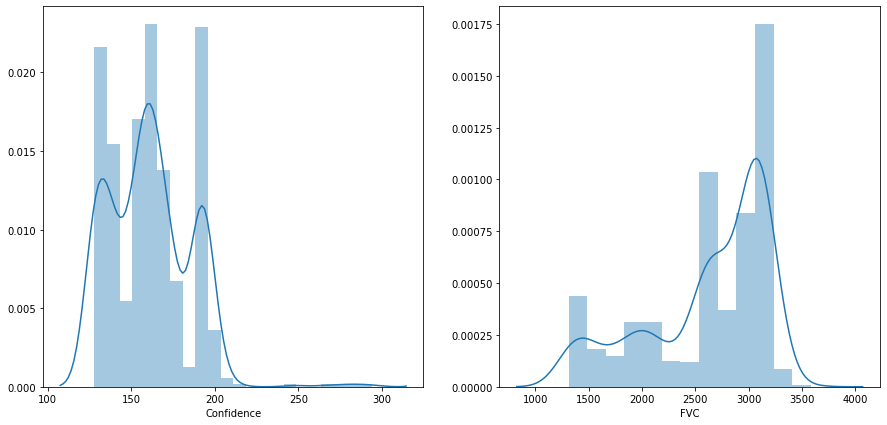

In [51]:
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.distplot(sub.Confidence)
plt.subplot(122)
sns.distplot(sub.FVC);

In [52]:
print(sub.shape)
sub

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3183.183105,267
1,ID00421637202311550012437_-12,3321.697998,278
2,ID00422637202311677017371_-12,2702.875427,248
3,ID00423637202312137826377_-12,3583.536214,294
4,ID00426637202313170790466_-12,3395.165955,285
...,...,...,...
725,ID00419637202311204720264_133,2525.196452,160
726,ID00421637202311550012437_133,2922.499369,189
727,ID00422637202311677017371_133,1311.705566,128
728,ID00423637202312137826377_133,1836.908183,136


In [53]:
sub.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2619.727227,160.969863
std,570.542294,24.039843
min,1311.705566,128.000000
25%,2240.289375,140.000000
50%,2763.661682,160.000000
75%,3086.550847,175.000000
max,3583.536214,294.000000


In [54]:
!ls

__notebook__.ipynb  submission.csv
